Processing Masks: 100%|██████████| 144/144 [00:01<00:00, 73.68it/s]
C:\Users\USER\AppData\Local\Temp\ipykernel_24860\1293530317.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(



=== Hasil Distribusi Kelas ===
                  Class  Pixel Count  Percentage
0            Background      3974726    1.822559
1      Building-flooded     44707314   20.499953
2  Building-non-flooded     19640144    9.005731
3          Road-flooded     52326728   23.993735
4      Road-non-flooded     27484664   12.602732
5                 Water     12894212    5.912472
6                  Tree     45687218   20.949275
7               Vehicle     11217458    5.143618
8                 Grass       152496    0.069925


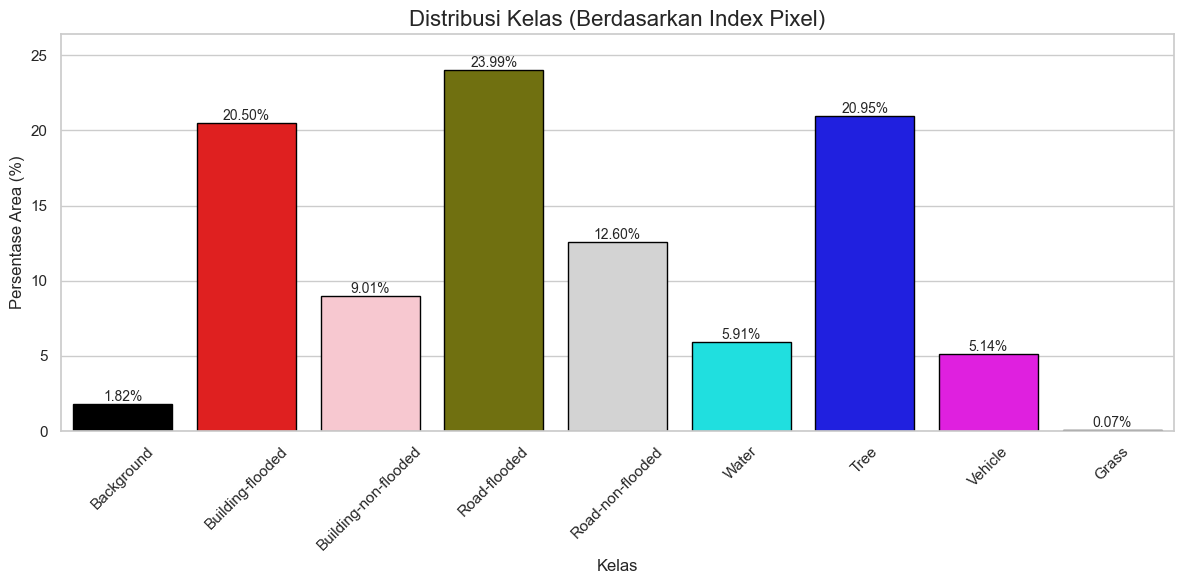

In [3]:
import os
import glob
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import matplotlib.patches as mpatches

DATASET_ROOT = './dataset_split/'

CLASS_NAMES = [
    'Background',           
    'Building-flooded',     
    'Building-non-flooded', 
    'Road-flooded',         
    'Road-non-flooded',     
    'Water',                
    'Tree',                 
    'Vehicle',              
    'Grass'                 
]

LABEL_COLORS = [
    [0, 0, 0],          # 0: Background 
    [255, 0, 0],        # 1: Building-flooded 
    [255, 192, 203],    # 2: Building-non-flooded
    [128, 128, 0],      # 3: Road-flooded 
    [211, 211, 211],    # 4: Road-non-flooded 
    [0, 255, 255],      # 5: Water 
    [0, 0, 255],        # 6: Tree 
    [255,0, 255],      # 7: Vehicle 
    [0, 255, 0],        # 8: Grass 
]

PLOT_COLORS = [
    '#000000', 
    '#FF0000', 
    '#FFC0CB', 
    '#808000', 
    '#D3D3D3', 
    '#00FFFF', 
    '#0000FF', 
    '#FF00FF', 
    '#00FF00', 
]

def calculate_distribution_torch(dataset_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_classes = len(CLASS_NAMES)
    total_counts = torch.zeros(num_classes, dtype=torch.long).to(device)
    
    label_files = []
    subsets = ['train', 'val', 'test']
    
    for subset in subsets:
        lbl_dir = os.path.join(dataset_path, subset, f'{subset}-label-img')
        if os.path.exists(lbl_dir):
            files = glob.glob(os.path.join(lbl_dir, '*'))
            label_files.extend(files)
    
    for lbl_path in tqdm(label_files, desc="Processing Masks"):
        img_np = cv2.imread(lbl_path, cv2.IMREAD_UNCHANGED)
        
        if img_np is None:
            continue
            
        if len(img_np.shape) == 3:
            img_np = img_np[:, :, 0]
        
        img_tensor = torch.from_numpy(img_np).long().to(device).flatten()
        
        counts = torch.bincount(img_tensor, minlength=num_classes)
        
        if len(counts) > num_classes:
            counts = counts[:num_classes]
            
        total_counts += counts

    return total_counts.cpu().numpy()


def plot_results(counts):
    total_pixels = np.sum(counts)
    
    data = []
    for idx, count in enumerate(counts):
        percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0
        data.append({
            'Class': CLASS_NAMES[idx],
            'Pixel Count': count,
            'Percentage': percentage
        })
        
    df = pd.DataFrame(data)
    
    print("\n=== Hasil Distribusi Kelas ===")
    print(df)
    
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    barplot = sns.barplot(
        data=df,
        x='Class',
        y='Percentage',
        palette=PLOT_COLORS,
        edgecolor='black'
    )
    
    plt.title('Distribusi Kelas (Berdasarkan Index Pixel)', fontsize=16)
    plt.xlabel('Kelas', fontsize=12)
    plt.ylabel('Persentase Area (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, max(df['Percentage']) * 1.1) 
    
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.2f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


if os.path.exists(DATASET_ROOT):
    pixel_counts = calculate_distribution_torch(DATASET_ROOT)
    plot_results(pixel_counts)
else:
    print(f"Error: Path {DATASET_ROOT} tidak ditemukan.")

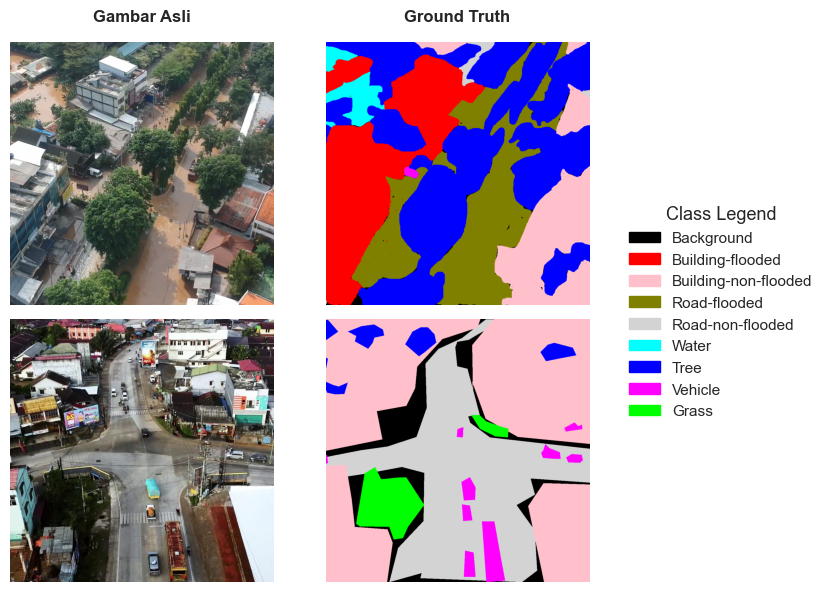

In [5]:
def crop_center_square(img):
    width, height = img.size
    new_dim = min(width, height)
    
    left = (width - new_dim) / 2
    top = (height - new_dim) / 2
    right = (width + new_dim) / 2
    bottom = (height + new_dim) / 2
    
    return img.crop((left, top, right, bottom))

def save_visualization_result(image_ids):
    sns.set_style("white")
    
    num_images = len(image_ids)
    
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(8, 3 * num_images))
    
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    plt.subplots_adjust(left=0.05, right=0.82, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

    for i, img_id in enumerate(image_ids):
        original_filename = f"{img_id}.png"
        ground_truth_filename = f"{img_id}_lab_mapped.png"
        
        ax_orig = axes[i, 0]
        if os.path.exists("sample_lokal/"+original_filename):
            img = Image.open("sample_lokal/"+original_filename).convert("RGB")
            img = crop_center_square(img) 
            ax_orig.imshow(img)
        else:
            ax_orig.text(0.5, 0.5, "Not Found", ha='center')
        
        if i == 0:
            ax_orig.set_title("Gambar Asli", fontsize=12, fontweight='bold', pad=15)
        
        ax_orig.axis("off")
        
        ax_gt = axes[i, 1]
        if os.path.exists("sample_lokal/"+ground_truth_filename):
            gt_img = Image.open("sample_lokal/"+ground_truth_filename).convert("RGB")
            gt_img = crop_center_square(gt_img) 
            ax_gt.imshow(gt_img)
        else:
            ax_gt.text(0.5, 0.5, "Not Found", ha='center')

        if i == 0:
            ax_gt.set_title("Ground Truth", fontsize=12, fontweight='bold', pad=15)
            
        ax_gt.axis("off")

    patches = [
        mpatches.Patch(color=[c/255 for c in color], label=label)
        for label, color in zip(CLASS_NAMES, LABEL_COLORS)
    ]
    
    fig.legend(
        handles=patches,
        loc="center left",
        bbox_to_anchor=(0.83, 0.5), 
        title="Class Legend",
        fontsize="11",
        title_fontsize="13",
        frameon=False
    )
    
    plt.show(fig)

files = ["image_71", "image_130"]
save_visualization_result(files)